### Semantic_Segementation

In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import make_grid
#model and transforms
from torchvision.transforms.functional import convert_image_dtype
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision

In [7]:
# utilities for multiple images
def img_show(images):
    
    if not isinstance(images, list):
        #generalise case images to list
        images = [images]
    fig, axis = plt.subplots(ncols=len(images), squeeze=False)
    for i, image in enumerate(images):
        image = F.to_pil_image(image)
        axis[0,i].imshow(np.asarray(image))
        axis[0,i].set(xticklabels=[], yticklabels=[],xticks=[],yticks=[])
        

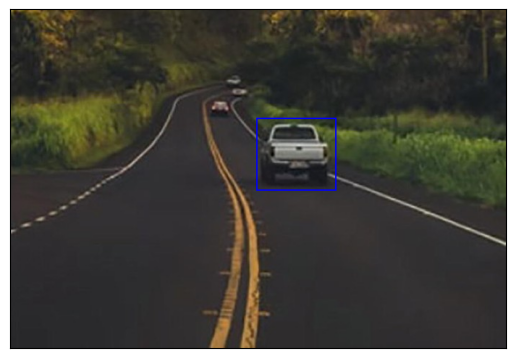

In [40]:

# get an images on which segmentation need to be done
#img1 = read_image("semantic_example_highway.jpg")
img1 = Image.open("semantic_example_highway.jpg")
img_tensor = ToTensor()(img1)
img_tensor_uint8 = (img_tensor * 255).to(torch.uint8)
box_car = torch.tensor([[340, 150, 450, 250]], dtype=torch.float)#(xmin,ymin,xmax,ymax)
colors = ['blue']

check_box = draw_bounding_boxes(img_tensor_uint8, box_car,colors = colors, width=2)
img_show(check_box)

In [42]:
# batch for images
batch_imgs = torch.stack([img_tensor_uint8])
batch_torch = convert_image_dtype(batch_imgs, dtype= torch.float)
batch_torch

tensor([[[[0.5098, 0.5647, 0.6196,  ..., 0.3020, 0.2980, 0.2941],
          [0.4902, 0.5412, 0.5843,  ..., 0.3020, 0.2980, 0.2980],
          [0.4627, 0.5059, 0.5412,  ..., 0.2980, 0.2980, 0.2980],
          ...,
          [0.1569, 0.1569, 0.1569,  ..., 0.1843, 0.1843, 0.1843],
          [0.1569, 0.1569, 0.1569,  ..., 0.1843, 0.1843, 0.1843],
          [0.1569, 0.1569, 0.1569,  ..., 0.1843, 0.1843, 0.1843]],

         [[0.4549, 0.5137, 0.5608,  ..., 0.2549, 0.2510, 0.2471],
          [0.4353, 0.4902, 0.5373,  ..., 0.2549, 0.2510, 0.2510],
          [0.4157, 0.4588, 0.5020,  ..., 0.2510, 0.2510, 0.2510],
          ...,
          [0.1569, 0.1569, 0.1569,  ..., 0.1765, 0.1765, 0.1765],
          [0.1569, 0.1569, 0.1569,  ..., 0.1765, 0.1765, 0.1765],
          [0.1569, 0.1569, 0.1569,  ..., 0.1765, 0.1765, 0.1765]],

         [[0.2627, 0.3059, 0.3373,  ..., 0.1608, 0.1569, 0.1451],
          [0.2431, 0.2863, 0.3098,  ..., 0.1608, 0.1569, 0.1490],
          [0.2196, 0.2549, 0.2706,  ..., 0

In [43]:
model = fcn_resnet50(pretrained=True, progress=False)
#swithcing on eval mode
model = model.eval()
#standdart normalizing based on train config
normalized_batch_torch = F.normalize(batch_torch,mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))
result = model(normalized_batch_torch)['out']

C:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth


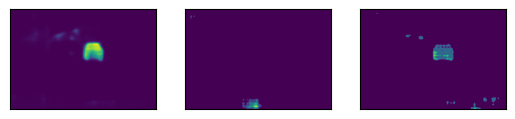

In [45]:
classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat','bottle', 'bus',
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog','horse', 'motorbike',
           'person', 'pottedplant', 'sheep', 'sofa', 'train','tvmonitor']
class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}

normalized_out_masks = torch.nn.functional.softmax(result,dim=1)
car_mask = [
    normalized_out_masks[img_idx, class_to_idx[cls]]
    for img_idx in range(batch_torch.shape[0])
    for cls in ('car','pottedplant','bus')
]
img_show(car_mask)

### Instance Segmentation

#### For faster R_CNN

In [48]:
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()
result = faster_rcnn_model(x)

C:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:27<00:00, 5.99MB/s]


#### For MobilesNet

In [49]:
x = [torch.rand(3,300,400),torch.rand(3,500,400)]
mobilenet_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)
mobilenet_model.eval()
result = mobilenet_model(x)

C:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|█████████████████████████████████████████████████████████████████████████████| 74.2M/74.2M [00:15<00:00, 4.94MB/s]


#### For RetinaNet

In [51]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
retinanet_model.eval()
result = retinanet_model(x)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|███████████████████████████████████████████████████████████████████████████████| 130M/130M [01:13<00:00, 1.86MB/s]


In [52]:
result

[{'boxes': tensor([[0.0000e+00, 1.4349e+00, 4.0000e+02, 3.0000e+02],
          [0.0000e+00, 9.5777e+00, 4.0000e+02, 2.9804e+02],
          [1.1594e+00, 0.0000e+00, 4.0000e+02, 3.0000e+02],
          [1.1594e+00, 0.0000e+00, 4.0000e+02, 3.0000e+02],
          [1.1594e+00, 0.0000e+00, 4.0000e+02, 3.0000e+02],
          [0.0000e+00, 1.1974e-01, 4.0000e+02, 3.0000e+02],
          [1.1594e+00, 0.0000e+00, 4.0000e+02, 3.0000e+02]],
         grad_fn=<StackBackward0>),
  'scores': tensor([0.1530, 0.1200, 0.1169, 0.0952, 0.0814, 0.0669, 0.0660],
         grad_fn=<IndexBackward0>),
  'labels': tensor([72, 28,  9,  7,  3, 64, 65])},
 {'boxes': tensor([[  7.0910,   4.7449, 400.0000, 500.0000],
          [  7.0910,   4.7449, 400.0000, 500.0000]], grad_fn=<StackBackward0>),
  'scores': tensor([0.0647, 0.0541], grad_fn=<IndexBackward0>),
  'labels': tensor([72, 64])}]

#### For Single Shot Detection

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
ssd_model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
ssd_model.eval()
result = ssd_model(x)